In [1]:
import numpy as np
import scipy.io as sio 
import math
import matplotlib.pyplot as plt
from ntfmodel import *
from utils import *


C:\Users\wilo_\anaconda3\envs\tf-gpu\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


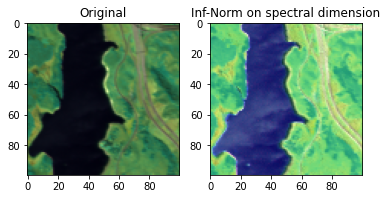

[I,J,K]=>[100,100,198]   [Lr,R]=>[12,4]


In [2]:
##########################################################################-----
# Load hsi in matlab format
datapath = 'data/'

trials = range(1)

# Replace fn with the dataset to be factorized
# filenames = ['h01-samson', 'h02-jasper','h03-urban']
fn = 'h02-jasper'
             
parms = LrModelParameters()
parms.lrate = 0.001
parms.MaxDelta = 1e-8
AbundanceThreshold = 0.95

# Load and plot input HSI
matdict = sio.loadmat(datapath + fn)
Yin = matdict['hsiten']
Ymax = np.max(Yin)
Yn = Yin/Ymax
# Normalize with inifinity norm along spectral dimension
Ynorm = np.linalg.norm(Yn, ord=np.inf, axis=2, keepdims=True)
Y = Yn/Ynorm
plt.subplot(1,2,1)
plt.imshow(hsi2rgb(Yn,rgb=False))
plt.title('Original')
plt.subplot(1,2,2)
plt.title('Inf-Norm on spectral dimension')
plt.imshow(hsi2rgb(Y,rgb=False))
plt.show()

# Get reference endmembers and expected
# Low rank spectral parameter R
Sgt = matdict['Sgt']
Sname = matdict['Sname']
[I,J,K] = Y.shape
[K,R] = Sgt.shape

# Compute Spatial low rank parameter Lr
Lr = int(np.maximum(I,J)**2/(R*K))
print(f'[I,J,K]=>[{I},{J},{K}]   [Lr,R]=>[{Lr},{R}]')

[I,J,K]=>[100,100,198]  [Lr,R]=>[12,4] | 2.730e-03 | 9.942e-09 |     11640 |  203.6 |   57


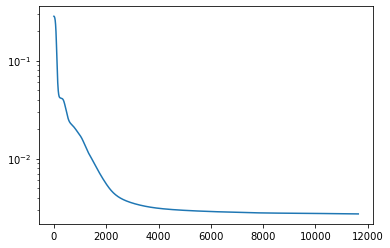

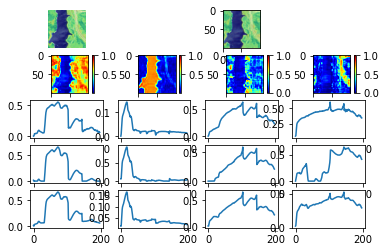

Trial: 1 sad:  0.0592  0.1697  0.0835  0.0645 aavg: 0.0942  rmse:  0.0453  0.0353  0.0513  0.0394 ravg: 0.0428


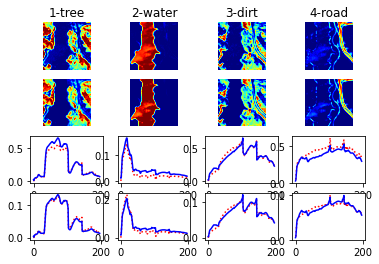

In [3]:
for i in trials:
    # Instanciate Model
    model = LrModel(Y,Lr,R,seed=i,parms=parms)
    results = model.run_optimizer()
    (cost_vector, delta, it, et) = results
    str1 = f'[I,J,K]=>[{I},{J},{K}]  [Lr,R]=>[{Lr},{R}] '
    str2 = f'|{cost_vector[-1]:10.3e} |{delta:10.3e} '
    str3 = f'|{it:10d} |{it/et:7.1f} |{et:5.0f}'
    print(str1 + str2 + str3)
    plt.semilogy(cost_vector)
    plt.show()

    # Compute endmembers using spatial components
    # and reconstructed tensor
    Sprime = get_endmembers(model, AbundanceThreshold, 
        norms=Ynorm)

    # Compare to reference (ground truth data
    # Reorder endmembers according to closest match
    (Sprime,p) = reorder(Sprime,Sgt)
    plot_decomposition(model,Sgt,Sprime,p)
    plt.show()

    # Compute Fully Constrained Least Squares
    A = fcls_np(Y,Sprime,norms=Ynorm)
    Agt = read_agt(matdict)
    nx = math.floor(matdict['nx'])
    mtx = compute_metrics(i,Sgt, Sprime, A, Agt)
    plot_abundance(Agt,A,nx)
    plot_all(Agt,A,nx,model,Sgt,Sprime,p,Sname)
    plt.show()


